# Main Program file for Cancer Predictive Model (Jupyter Notebook Version)
## By: Group CL_04

### Importing Libraries

In [4]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os, random, shutil
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from PIL import Image

### Dividing Dataset (70% training, 30% testing)

In [5]:
def img_train_test_split(root_dir, classes_dir, test_ratio):
    '''
    This function splits a folder with subfolders into train and test datasets
    :param root_dir: a string corresponding to the file path of the folder of subfolders of images
    :param classes_dir: a list of strings of subfolder names
    :param test_ratio: a float of the ratio of test dataset to train dataset
    :return: None
    '''

    for cls in classes_dir:
        # create a new train and test directory for cls
        os.makedirs(root_dir + 'train/' + cls)
        os.makedirs(root_dir + 'test/' + cls)

        # get pathname of cls
        src = root_dir + cls

        # split the filenames into chosen training and testing ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                   [int(len(allFileNames) * (1 - test_ratio))])

        # copy images into new train folder for cls subfolder
        for name in train_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'train/' + cls)

        # copy images into new test folder for cls subfolder
        for name in test_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'test/' + cls)
    return None

In [6]:
classes_dir = ['MSIMUT_JPEG', 'MSS_JPEG']
test_ratio = 0.3

In [1]:
# root_dir: filepath of coad_msi_mss with '/' at the back
# root_dir = '/Users/vionnietan/Desktop/trial_dataset/'
# root_dir = '/Users/elainealverina/Desktop/trial_dataset/'

root_dir = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/'

In [7]:
img_train_test_split(root_dir, classes_dir, test_ratio)

## Custom Dataset

In [9]:
class CustomCancerDataset(Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('jpg')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['MSIMUT_JPEG','MSS_JPEG']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        
        # Ensures that index is not out of bounds
        # Since classes have different number of images (class imbalance problem)
        index = index % len(self.images[class_name])
        index_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], index_name)
        image = Image.open(image_path).convert('RGB')
        
        # Return the transformed image and its class label
        return self.transform(image), self.class_names.index(class_name)

### Data Augmentation and Normalization

In [10]:
# batch_size = 128
learn_rate = 1e-3

data_transformation_train = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
data_transformation_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#root_dir_train = '/Users/vionnietan/Desktop/trial_dataset/train'
root_dir_train = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/train'
#root_dir_train = '/Users/elainealverina/Desktop/trial_dataset/train'

#root_dir_test = '/Users/vionnietan/Desktop/trial_dataset/test'
root_dir_test = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/test'
#root_dir_test = '/Users/elainealverina/Desktop/trial_dataset/test'


train_image_dataset = datasets.ImageFolder(root = root_dir_train, transform=data_transformation_train)
test_image_dataset = datasets.ImageFolder(root = root_dir_test, transform=data_transformation_test)



### Prepare DataLoader

In [11]:
train_image_dataloader = DataLoader(train_image_dataset, batch_size=128, shuffle=True)
test_image_dataloader = DataLoader(test_image_dataset, batch_size=128, shuffle=True)
# Switch to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data Visualization (Display some images)

In [13]:
#class_names = train_image_dataset.class_names
def show_image(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        if i < 5:
            plt.subplot(1, 6, i+1, xticks=[], yticks=[])
            image = image.cpu() if device else image
            image = image.numpy().transpose((1, 2, 0))

            # Denormalize image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)
            plt.imshow(image)
            colour = 'green' if preds[i] == labels[i] else 'red'
            
            plt.xlabel(f'{labels[i]}')
            plt.ylabel(f'{preds[i]}', color=colour)

    plt.show()

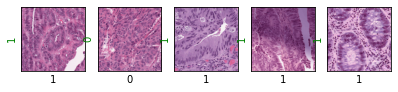

In [14]:
# Show Images of Training Data
images, labels = next(iter(train_image_dataloader))
show_image(images,labels, labels)

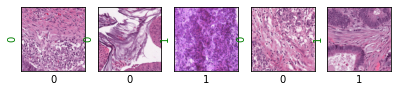

In [15]:
# Show Images of Testing Data
images_test, labels_test = next(iter(test_image_dataloader))
show_image(images_test,labels_test, labels_test)

### Creating the Model - Load resnet18

In [16]:
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# Classifier architecture to put on top of resnet18
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

# Using Adam Optimizer
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0001)

In [19]:
def show_preds():
    resnet18.eval()    # set to evaluation mode
    images, labels = next(iter(test_image_dataloader))
    out = resnet18(images)
    _ , preds = torch.max(out, dim=1)
    show_image(images, labels, preds)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


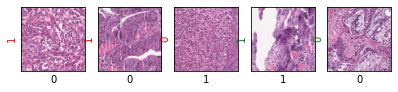

In [20]:
# Need to add labels to graph
show_preds()

### Freeze Parameters

### Training Model

In [21]:
def train(epochs):
    print('Started training...')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()   # set to training mode
        
        for train_step, (images, labels) in enumerate(train_image_dataloader):
            
            # Refresh optimizer and set gradients to zero
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('\nEvaluating at step:', train_step)
                acc = 0.
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(test_image_dataloader):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _ , preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                    
                val_loss /= (val_step + 1)
                acc /= len(test_image_dataset)
                print(f'Val loss = {val_loss:.4f}, Accuracy = {acc:.4f}')
                # show_preds()
                
                resnet18.train()
                
                if acc > 0.97:
                    print('\nPerformance condition satisifed, hence stopping...')
                    return
                
        train_loss /= (train_step+1)
        print(f'\nTraining loss = {train_loss:.4f}')

In [22]:
train(epochs=3)

Started training...
Starting epoch 1/3

Evaluating at step: 0
Val loss = 1.0192, Accuracy = 0.4825

Evaluating at step: 20
Val loss = 0.7017, Accuracy = 0.6906

Training loss = 0.7586
Starting epoch 2/3

Evaluating at step: 0
Val loss = 0.6159, Accuracy = 0.7004

Evaluating at step: 20
Val loss = 0.5868, Accuracy = 0.7342

Training loss = 0.3795
Starting epoch 3/3

Evaluating at step: 0
Val loss = 0.5782, Accuracy = 0.7446

Evaluating at step: 20
Val loss = 0.5759, Accuracy = 0.7514

Training loss = 0.2101


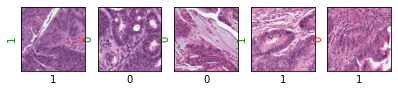

In [23]:
show_preds()

### Testing